### Semana 5 Día 2

## AutoGen AgentChat - Profundizando...

1. Conversación multimodal
2. Salidas estructuradas
3. Uso de herramientas LangChain
4. Equipos

...y una sorpresa especial

In [2]:
from io import BytesIO
import requests
from autogen_agentchat.messages import TextMessage, MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from IPython.display import display, Markdown
from pydantic import BaseModel, Field
from typing import Literal

load_dotenv(override=True)


True

### Una conversación multi-modal


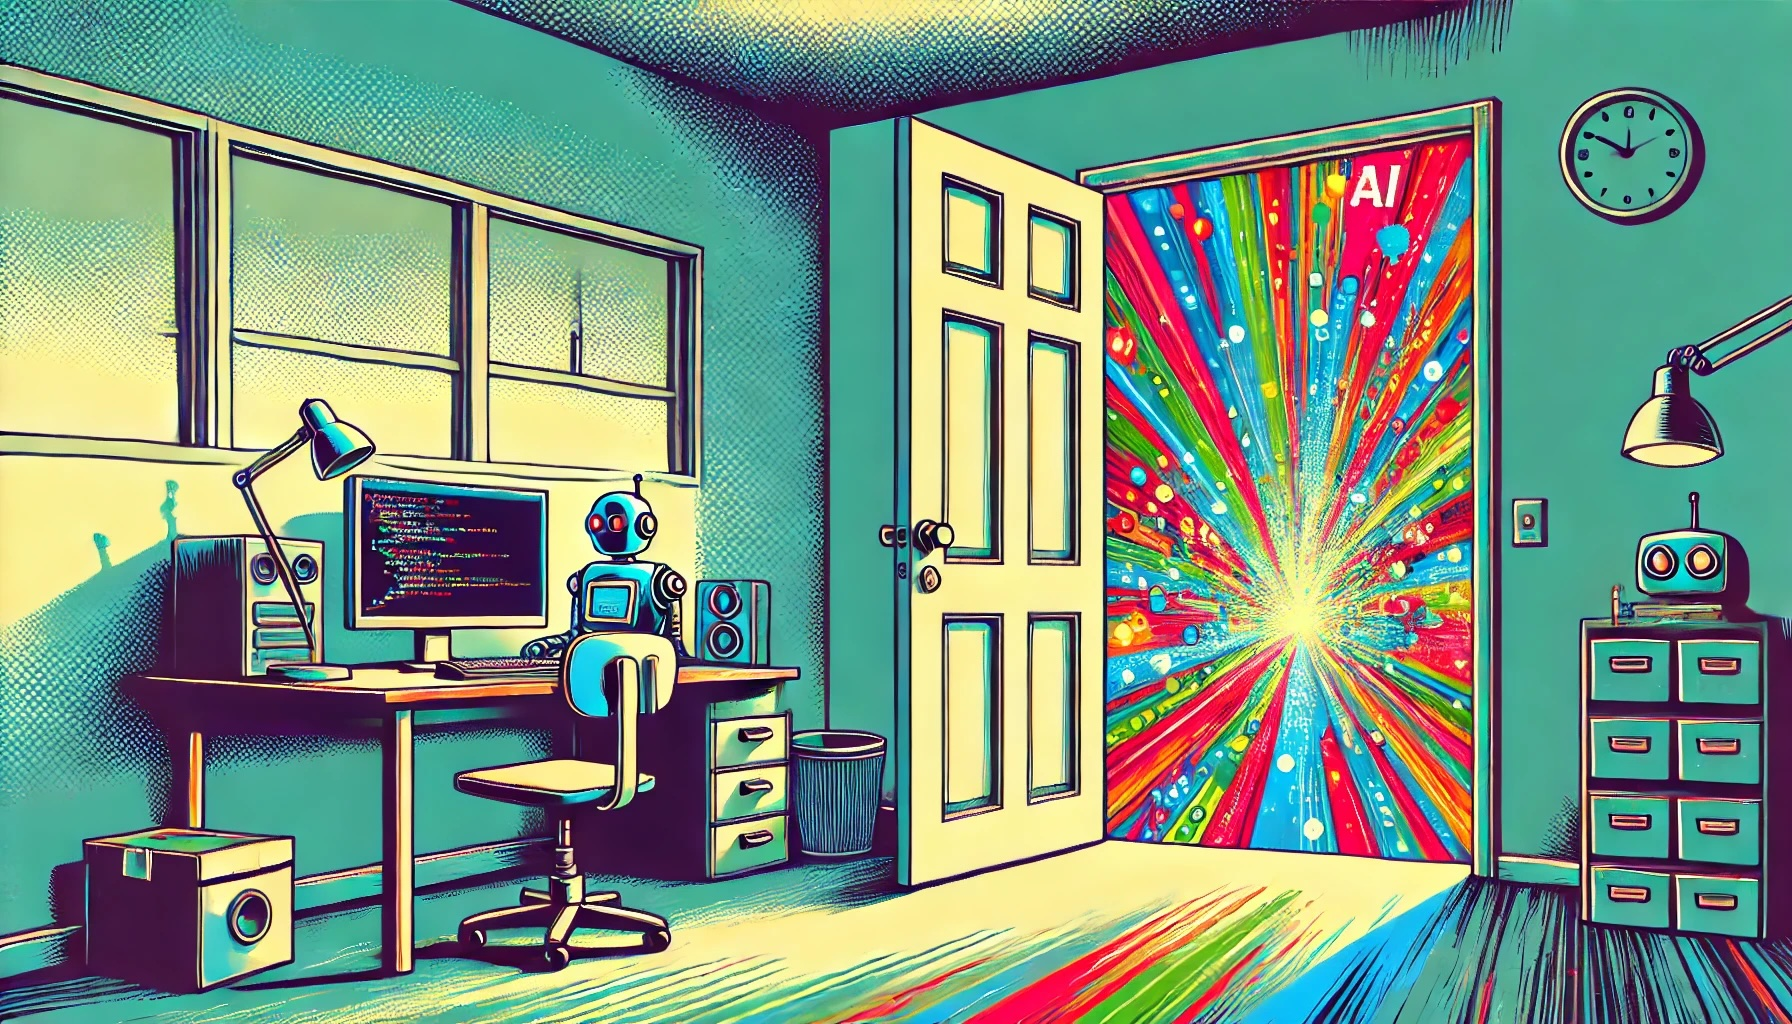

In [3]:
url = "https://edwarddonner.com/wp-content/uploads/2024/10/from-software-engineer-to-AI-DS.jpeg"

pil_image = Image.open(BytesIO(requests.get(url).content))
img = AGImage(pil_image)
img

In [4]:
multi_modal_message = MultiModalMessage(content=["Describe el contenido de esta imagen en detalle", img],
                                         source="User")

In [5]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

describer = AssistantAgent(
    name="description_agent",
    model_client=model_client,
    system_message="Eres bueno describiendo imágenes",
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
display(Markdown(reply))

La imagen muestra un interior llamativo y colorido que parece pertenecer a una habitación de estilo moderno. A la izquierda, hay un escritorio de madera con una computadora que muestra líneas de código en la pantalla. Junto a la computadora, hay un altavoz pequeño y una lámpara de escritorio que emite una luz suave. En la silla frente a la computadora hay un pequeño robot con un diseño amigable, que parece estar curioso o interactuando con la computadora.

A la derecha, hay una puerta abierta que da acceso a un mundo exterior vibrante y dinámico. A través de la puerta, se puede ver una explosión de colores brillantes y formas abstractas, destacando el término "AI" (Inteligencia Artificial) en la parte superior. Esta explosión de color contrasta fuertemente con el entorno más cálido y neutro de la habitación.

En la pared opuesta hay un reloj y un pequeño mueble con cuatro cajones. El suelo parece de madera, y hay un cubo de basura al lado del escritorio. Todos los elementos de la imagen parecen evocan un ambiente de creatividad y tecnología, contrastando lo cotidiano con lo extraordinario.

### Salidas Estructuradas!

Autogen AgentChat hace que sea muy sencillo.

In [6]:

class ImageDescription(BaseModel):
    scene: str = Field(description="Brevemente, el escenario general de la imagen")
    message: str = Field(description="El punto que la imagen está tratando de transmitir")
    style: str = Field(description="El estilo artístico de la imagen")
    orientation: Literal["retrato", "paisaje", "cuadrada"] = Field(description="La orientación de la imagen")


In [8]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

describer = AssistantAgent(
    name="description_agent",
    model_client=model_client,
    system_message="Eres bueno describiendo imágenes en detalle",
    output_content_type=ImageDescription,
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
reply

ImageDescription(scene='Un interior moderno y vibrante que representa un espacio de trabajo tecnológico.', message='La imagen transmite una sensación de conexión entre la tecnología y la creatividad, simbolizando la influencia del arte en la inteligencia artificial.', style='Estilo colorido y artístico, con fuertes contrastes y líneas dinámicas que parecen emanar de la puerta.', orientation='paisaje')

In [9]:
import textwrap
print(f"Escenario:\n{textwrap.fill(reply.scene)}\n\n")
print(f"Mensaje:\n{textwrap.fill(reply.message)}\n\n")
print(f"Estilo:\n{textwrap.fill(reply.style)}\n\n")
print(f"Orientación:\n{textwrap.fill(reply.orientation)}\n\n")

Escenario:
Un interior moderno y vibrante que representa un espacio de trabajo
tecnológico.


Mensaje:
La imagen transmite una sensación de conexión entre la tecnología y la
creatividad, simbolizando la influencia del arte en la inteligencia
artificial.


Estilo:
Estilo colorido y artístico, con fuertes contrastes y líneas dinámicas
que parecen emanar de la puerta.


Orientación:
paisaje




### Usando las herramientas de LangChain desde AutoGen

In [13]:
# AutoGen's wrapper:

from autogen_ext.tools.langchain import LangChainToolAdapter

# LangChain tools:

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.agent_toolkits import FileManagementToolkit
# from langchain.agents import Tool
from langchain_core.tools import Tool

prompt = """Tu tarea es encontrar un vuelo directo de ida de BCN a JFK en septiembre de 2025.
Primero, busca en línea ofertas atractivas.
Después, anota todas las ofertas en un archivo llamado flights.md con todos los detalles.
Finalmente, selecciona la que consideres mejor y responde con un breve resumen.
Responde solo con el vuelo seleccionado, y solo después de haber escrito los detalles en el archivo."""


serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="Útil para cuando necesitas buscar en Internet.")
autogen_serper = LangChainToolAdapter(langchain_serper)
autogen_tools = [autogen_serper]

langchain_file_management_tools = FileManagementToolkit(root_dir="sandbox").get_tools()
for tool in langchain_file_management_tools:
    autogen_tools.append(LangChainToolAdapter(tool))

for tool in autogen_tools:
    print(tool.name, tool.description)

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
agent = AssistantAgent(name="searcher", model_client=model_client, tools=autogen_tools, reflect_on_tool_use=True)
message = TextMessage(content=prompt, source="user")
result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

ValidationError: 1 validation error for GoogleSerperAPIWrapper
  Value error, Did not find serper_api_key, please add an environment variable `SERPER_API_KEY` which contains it, or pass `serper_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error

In [9]:
# Ahora necesitamos llamar nuevamente al agente para escribir el archivo.

message = TextMessage(content="OK procedemos", source="user")

result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

[FunctionCall(id='call_LggFxMZU5ogMqavNkVdmlUc5', arguments='{"file_path":"flights.md","text":"**Vuelos directos de BCN a JFK - Septiembre 2025**\\n\\n1. **Aerolínea**: Iberia  \\n   **Salida**: 09 de septiembre de 2025  \\n   **Regreso**: (solo ida)  \\n   **Precio**: EUR 421  \\n   **Detalles adicionales**: Vuelo directo, duración aproximada 8 horas.  \\n\\n2. **Aerolínea**: Vueling  \\n   **Salida**: 09 de septiembre de 2025  \\n   **Regreso**: (solo ida)  \\n   **Precio**: EUR 400  \\n   **Detalles adicionales**: Vuelo directo.  \\n","append":false}', name='write_file')]
[FunctionExecutionResult(content='File written successfully to flights.md.', name='write_file', call_id='call_LggFxMZU5ogMqavNkVdmlUc5', is_error=False)]


He guardado los detalles de los vuelos en el archivo flights.md. 

Ahora, seleccionaré la mejor opción y proporcionaré un breve resumen. La opción seleccionada es:

**Aerolínea**: Iberia  
**Salida**: 09 de septiembre de 2025  
**Precio**: EUR 421  
**Detalles**: Vuelo directo, duración aproximada 8 horas.

Este vuelo de Iberia es la mejor opción debido a su duración directa y una ligera diferencia de precio respecto a la opción de Vueling. 

TERMINATE

### Interacciones con el Equipo

In [10]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import  TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat

from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="Útil para cuando necesitas buscar en Internet.")
autogen_serper = LangChainToolAdapter(langchain_serper)

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")


prompt = """Busca un vuelo directo de ida de BCN a JFK en septiembre de 2025. Primero busca en línea ofertas atractivas.
Finalmente, selecciona la que consideres mejor y responde con un breve resumen.
Cada vez que te llamen, deberias responder con una opción diferente."""


primary_agent = AssistantAgent(
    "primary",
    model_client=model_client,
    tools=[autogen_serper],
    system_message="Eres un asistente de IA que busca ofertas prometedoras en vuelos. Responde solo con una opción y asegúrate de que cada una es diferente de las anteriores. Incorpora cualquier retroalimentación que recibas.",
)

evaluation_agent = AssistantAgent(
    "evaluator",
    model_client=model_client,
    system_message="Proporciona retroalimentación constructiva. Responde con 'APROBAR' cuando tu retroalimentación sea positiva. Si solo has visto una respuesta, no la debes aprobar aún; necesitas ver más",
)

text_termination = TextMentionTermination("APROBAR")

# Gracias a Peter A por agregar el max_turns - de lo contrario, esto podría entrar en un bucle..

team = RoundRobinGroupChat([primary_agent, evaluation_agent], termination_condition=text_termination, max_turns=20)



In [11]:
result = await team.run(task=prompt)
for message in result.messages:
    print(f"{message.source}:\n{message.content}\n\n")


user:
Busca un vuelo directo de ida de BCN a JFK en septiembre de 2025. Primero busca en línea ofertas atractivas.
Finalmente, selecciona la que consideres mejor y responde con un breve resumen.
Cada vez que te llamen, deberias responder con una opción diferente.


primary:
[FunctionCall(id='call_f0S2KbQvGmiasrx4SGZU9YcV', arguments='{"query":"direct flight one way BCN to JFK September 2025 deals"}', name='internet_search')]


primary:
[FunctionExecutionResult(content="Cheap Flights from Barcelona (BCN) to New York (JFK) start at $210 for one-way and $352 for round trip. Earn your airline miles on top of our rewards! Flights from Barcelona to New York. Use Google Flights to plan your next trip and find cheap one way or round trip flights from Barcelona to New York. Missing: September 2025. Book our best prices between Barcelona and New York within the next 6 months ; Jul 2025 · EUR589 · Seen: 1 day ago ; Sep 2025 · EUR421 · Seen: 1 day ago ; Dec 2025. Missing: direct | Show results wit

### Redoble..

## Introducimos el MCP!

Nuestro primer vistazo al Protocolo de Contexto de Modelo de Anthropic:

Autogen facilita el uso de herramientas MCP, al igual que las herramientas LangChain.

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/stop.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Un momento, un problema considerable para los usuarios de PC con Windows</h2>
<span style="color:#ff7800;">Tengo malas noticias. Hay un problema al ejecutar servidores MCP en PC con Windows; Mac y Linux funcionan correctamente. Este problema se conoce desde el 4 de mayo de 2025. Le pedí a o3 de Deep Research que buscara soluciones alternativas; <a href="https://chatgpt.com/share/6817bbc3-3d0c-8012-9b51-631842470628">confirmaron el problema</a> y la solución alternativa.<br/><br/>
La solución alternativa es un poco aburrida. Se trata de aprovechar "WSL", el enfoque de Microsoft para ejecutar Linux en tu PC. ¡Tendrás que seguir más instrucciones de configuración! Pero es rápido, y varios estudiantes han confirmado que les funciona a la perfección. Entonces, este laboratorio y los laboratorios MCP de la semana 6 funcionan. Además, WSL es una excelente manera de desarrollar software en tu PC con Windows. También puedes omitir esta última celda, pero tendrás que volver a ella al comenzar la semana 6.<br/>
Las instrucciones de configuración de WSL se encuentran en la carpeta Setup, <a href="../setup/SETUP-WSL.md">en el archivo llamado SETUP-WSL.md</a>. Espero que esto solo te retrase un poco; deberías estar listo para usar pronto. ¡Qué alegría trabajar con tecnología de vanguardia!<br/><br/>
Muchas gracias al estudiante Kaushik R. por mencionar que esto es necesario aquí, así como en la semana 6. ¡Gracias, Kaushik!
</span>
        </td>
    </tr>
</table>

In [13]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools

# Obtenemos la herramienta fetch desde mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
fetcher = await mcp_server_tools(fetch_mcp_server)

# Creamos un agente que puede usar la herramienta fetch.
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
agent = AssistantAgent(name="fetcher", model_client=model_client, tools=fetcher, reflect_on_tool_use=True)  # type: ignore

# Hacemos que el agente busque el contenido de una URL y lo resuma.
result = await agent.run(task="Revisa https://cursos.frogamesformacion.com y resume lo que aprendes. Responde en Markdown.")
display(Markdown(result.messages[-1].content))

# Resumen de Frogames Formación

Frogames Formación es una plataforma de cursos online diseñada para toda la familia, enfocada en ofrecer educación de calidad mientras aprendes divirtiéndote. A continuación, se destacan las características principales del sitio:

### Características de la Plataforma

- **Cursos y Rutas Temáticas**: Ofrecen cursos organizados en rutas temáticas para aprender de manera progresiva y estructurada.
  
- **Instructores Expertos**: Cuentan con un equipo de profesionales y expertos que guían a los estudiantes a lo largo de su proceso de aprendizaje.

- **Certificados Blockchain**: Al completar los cursos, se otorgan certificados verificados por blockchain que son fácilmente compartibles en redes sociales, lo que mejora el currículum de los estudiantes.

- **Actualizaciones Frecuentes**: Los cursos se actualizan semanalmente y hay nuevos contenidos regularmente, lo que permite a los estudiantes estar al día con los últimos avances en sus áreas de interés.

### Testimonios de Estudiantes

Frogames cuenta con más de 500,000 estudiantes satisfechos. Aquí algunos testimonios:

- **Variedad de Cursos**: Los estudiantes valoran la variedad y la especialización de los cursos, afirmando que son prácticos y retadores.
  
- **Comunidad de Aprendizaje**: Muchos destacan que disfrutar aprender en un ambiente comunitario donde también se crece tanto personal como profesionalmente.

- **Acceso a Todos los Cursos**: Los que optan por la suscripción anual mencionan las ventajas de acceder a una amplia gama de cursos y nuevos contenidos cada semana.

- **Calidad de la Enseñanza**: La calidad del equipo docente es un punto frecuentemente alabado, donde los estudiantes sienten que reciben un trato personalizado y efectivo.

### Conclusión

Frogames Formación busca crear una experiencia de aprendizaje integral, combinando diversión, retos educativos y un enfoque en el desarrollo de habilidades prácticas. Sus certificados blockchain son un valor añadido, y la satisfacción de los estudiantes es testimonio de la efectividad de la plataforma.

TERMINATE